# Analyse des commentaires
Dans ce notebook, nous allons regarder en détail les commentaires laissés par les utilisateurs.
Le travail sera divisé en deux parties : Construction du corpus et Début ? d'analyse des fréquences

In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import NMF, Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from itertools import product


from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def words_freq(data, corpus) -> pd.DataFrame:
    """
    Construction d'un dataframe avec la fréquence des mots dans un corpus
    """

    lem, occurences = np.unique(data['Lemma'], return_counts=True)

    df = pd.DataFrame({'Lemma': lem, 'Freq': occurences})
    nb_comments = data["Comment line"].nunique()
    df['Freq'] = df['Freq'].apply(lambda val: val/nb_comments)

    # Garder uniquement les lemmas qui appraissent dans le corpus
    #return df[df['Lemma'].isin(corpus)]
    return df

def construction_corpus(lemmas:pd.DataFrame, taille: int) -> dict:
    """ 
    Construction d'un corpus à partir d'une BDD de commentaires
    avis.colums = 'Comment title', 'Comment body'

    Retourne df avec mots du corpus et leurs fréquences, les 'taille' plus fréquentes
    """

    # Corpus creation from lemmatized dataframe
    lemmas = lemmas[~lemmas["Lemma"].isna()]
    lemmas = lemmas[lemmas['Part of speech'].isin(['ADJ', 'NOM', "VER", "NEG"])]
    lemmas = lemmas[~lemmas["Lemma"].isin(["bref", "bof", "excelent", "bon", "autre", "seul", "tendre", "fin"
                                           "super", "superbe", "juste", "jouable", "ca", "faire", "pouvoir", "ausi"])]
    lemmas = lemmas['Lemma'].to_numpy()

    # Occurencies calculation for each lemma
    lem, occ = np.unique(lemmas, return_counts=True)
    freq_lem = pd.DataFrame({'lemma': lem, 'freq': occ})

    freq_lem = freq_lem.sort_values(by=['freq'], ascending=False)
    return freq_lem.head(taille)['lemma'].to_numpy()

In [3]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()

rev_filter = rev_filter.assign(index=np.arange(0, rev_filter.shape[0]))
rev_filter_center, _= center_score(rev_filter)
rev_filter_center

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


,Game id,User id,Game name UI,Username,Datetime,Rating,Comment title,Comment body,index
0,6179,0,Mariposas,Monsieur Guillaume,2021-01-27 11:06:44,-0.162500,Voyages sur les ailes des papillons,"Lorsque le jeu est jeu, bon, réflexif, joli po...",0
1,6179,1,Mariposas,morlockbob,2020-10-18 10:04:21,0.331184,le festival de Michoacan,Comment continuer après un mega hit ? Simpleme...,1
2,6179,2,Mariposas,SwatSh,2021-02-01 08:35:08,-0.187143,Vivez la migration des monarques,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ...",2
3,6179,3,Mariposas,BSI40,2022-09-23 17:16:27,-0.705405,Manque un peu de souffle,Mariposas est plutôt beau avec un grand platea...,3
4,6179,4,Mariposas,Lilly,2020-11-03 17:30:05,-0.442857,Beau et Doux et Rapide,Mariposas est un jeu ou la tension va s'exacer...,4
...,...,...,...,...,...,...,...,...,...
96528,6025,128,Mag Blast,Pickouette,2009-11-23 12:28:54,-0.148148,Piou!!! Boum!!! Badaboum!!! Crac!!! Et re piou!!!,Petit jeu bien fun ou il faut faire des bruita...,96528
96529,6025,7597,Mag Blast,stanpower37,2011-07-14 12:29:01,-1.250000,star wars revisité,un jeu de vaisseau spaciaux assez sympa mais p...,96529
96530,6025,4560,Mag Blast,Xian9x,2008-11-06 12:28:51,0.777778,piou piou,"Mag blast est un jeu rapide, drole et sans pré...",96530
96531,6025,3346,Mag Blast,marreco,2007-11-07 12:28:47,-3.090909,peewww peeeww t mort,je n'ai pu qu'y jouer à 2 et c'est moyen. On a...,96531


### Corpus 5000 mots

In [4]:
lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv", index_col=0)
corpus = construction_corpus(lemmas, 5000) 
lemmas = lemmas[lemmas["Lemma"].isin(corpus)] # only words in corpus

# Joined lemmas
comments = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma" : "Comment"})
comments

,Comment line,Comment
0,0,voyage aile papillon jeu jeu joli sensible sty...
1,1,festival continuer apres mega hit apres oiseau...
2,2,vivre vin jeu parvenir simuler epopee applique...
3,3,manquer souffle plutot beau grand plateau peti...
4,4,beau doux rapide jeu tension aller cours|cour ...
...,...,...
94686,142459,boum re petit jeu bien fun falloir tirer adver...
94687,142460,star wars revisiter jeu vaisseau sympa joueur ...
94688,142461,jeu rapide drole pretention passer moment regl...
94689,142462,mort ne jouer moyen pas fouiller bien strategi...


### NMF 20 latent factors

In [5]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]
G

array([[0.14382481, 0.74444682, 0.54067499, ..., 0.10409893, 0.01784198,
        0.01026847],
       [1.15853361, 0.66935085, 0.70442709, ..., 0.38688394, 0.35072878,
        0.48537336],
       [0.55548329, 0.50590919, 0.54736474, ..., 0.41276769, 0.74742814,
        0.7906489 ],
       ...,
       [1.15378271, 0.75840296, 1.086939  , ..., 1.07757492, 0.46011419,
        0.59921417],
       [0.54360927, 0.94284411, 0.27739629, ..., 0.49414539, 0.32245009,
        0.58386953],
       [0.24266537, 0.68619341, 0.14901347, ..., 0.23433089, 0.74378474,
        0.94266405]])

### 30 KMeans games clusters 

In [6]:
sns.set_theme(rc={"figure.figsize":(6, 5)})
NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
kmeans.fit(G) 

games_clusters = pd.DataFrame(data={"Game id" : np.sort(games_ids), "Cluster" : kmeans.labels_})
games_clusters

,Game id,Cluster
0,6,12
1,15,1
2,25,21
3,28,24
4,34,24
...,...,...
2609,10507,14
2610,10508,8
2611,10514,24
2612,10531,15


In [7]:
# Séparation de la bdd 
positifs = rev_filter_center[rev_filter_center['Rating'] >= 0]
negatifs = rev_filter_center[rev_filter_center['Rating'] < 0]

print("Nombre d'avis negatif", len(negatifs)/len(rev_filter_center))
print("Nombre d'avis positif", len(positifs)/len(rev_filter_center))

Nombre d'avis negatif 0.43073353153843763
Nombre d'avis positif 0.5692664684615624


In [8]:
lemmas_pos = positifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_neg = negatifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_pos = lemmas_pos.drop(["index"], axis=1)
lemmas_neg = lemmas_neg.drop(["index"], axis=1)

lemmas_all = rev_filter[["User id", "Game id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_all = lemmas_all.drop(["index"], axis=1)
lemmas_all

,User id,Game id,Tokens,Len,Comment line,Part of speech,Lemma
0,0,6179,voyages,7,0,NOM,voyage
1,0,6179,ailes,5,0,NOM,aile
2,0,6179,papillons,9,0,NOM,papillon
3,0,6179,jeu,3,0,NOM,jeu
4,0,6179,jeu,3,0,NOM,jeu
...,...,...,...,...,...,...,...
3421376,4735,6025,ridicule,8,96532,ADJ,ridicule
3421377,4735,6025,cartes,6,96532,NOM,carte
3421378,4735,6025,rapport,7,96532,NOM,rapport
3421379,4735,6025,plateau,7,96532,NOM,plateau


In [9]:
comments_neg = lemmas_neg.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_neg = comments_neg.assign(pos_neg = "negative")

comments_pos = lemmas_pos.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_pos = comments_pos.assign(pos_neg = "positive")

comments_all = pd.concat([comments_neg, comments_pos])
comments_all_count = comments_all[["Game id", "pos_neg", "User id"]].groupby(["Game id", "pos_neg"]).count().rename(columns={"User id":"count"}).reset_index()

In [10]:
comments_neg[comments_neg["Lemma"].str.contains("must haver")]

,Comment line,Game id,User id,Lemma,pos_neg
11,40,8959,90,pearl game roll write adorer principe de trans...,negative
59,398,8959,603,game materiel materiel qualite format carte bi...,negative
136,1093,8300,172,epique part decouvrir jeu apres partie devoir ...,negative
151,1170,8093,386,pur petit merveille rendre accroc regle simple...,negative
302,2188,7282,1081,avis plateau marmot servir materiel impeccable...,negative
...,...,...,...,...,...
26700,92741,6692,4983,must haver game elegance subtilite rare combin...,negative
27307,94985,7738,2430,grand jeu multiple possibilite mettre decouvri...,negative
27354,95056,10312,1913,ptit prince donner voiler jeu venir etre ne co...,negative
27363,95069,10312,1926,apres avoir decouvrir version allemand cours|c...,negative


In [11]:
rev_neg_count = comments_neg["Game id"].value_counts().reset_index()
rev_pos_count = comments_pos["Game id"].value_counts().reset_index()

# Filter games so that each game has at least 10 pos and 10 neg reviews
games_preserved = rev_neg_count[rev_neg_count["Game id"].isin(rev_pos_count.loc[rev_pos_count["count"] >= 10, "Game id"])
                                & rev_neg_count["Game id"].isin(rev_neg_count.loc[rev_neg_count["count"] >= 10, "Game id"])]["Game id"].values
                                
mask = np.isin(np.sort(games_ids), games_preserved)

# Games clusters contains only games that were filtered
games_clusters = pd.DataFrame(data={"Game id":np.sort(games_ids)[mask], "Cluster":kmeans.labels_[mask]})

In [12]:
# Barplot the distribution of pos/neg comments
def plot_pos_neg_games(selected_games, comments_all_count, title, all=False):
    sns.set_theme(rc={"figure.figsize":(15, 6)})
    filtered = comments_all_count[comments_all_count["Game id"].isin(selected_games["Game id"])]
    if not all:
        filtered = filtered.head(50)
    ax = sns.barplot(data=filtered, x="Game id", y="count", hue="pos_neg", errorbar=None)
    ax.set_title(title)
    if all:
        ax.set(xticklabels=[])

def create_df(ngram_finder, ngram_stat):
        bigram_freq = ngram_finder.score_ngrams(ngram_stat)

        bigrams_df = pd.DataFrame(data=[list(info) for info in bigram_freq])

        bigrams_df[0] = bigrams_df[0].apply(list).apply(" ".join)
        bigrams_df = bigrams_df.rename(columns={0:"Lemma", 1:"Freq"})
        return bigrams_df

def get_Ngrams(game, ngram_finder, ngram_stat):
    comments_pos = lemmas_pos[lemmas_pos["Game id"] == game].groupby("Comment line")["Lemma"].apply(list)
    comments_neg = lemmas_neg[lemmas_neg["Game id"] == game].groupby("Comment line")["Lemma"].apply(list)
    
    #if comments_pos.size > 0:
    bigram_finder_pos = ngram_finder.from_documents(comments_pos)
    freq_pos = create_df(bigram_finder_pos, ngram_stat)
    #if comments_neg.size > 0:
    bigram_finder_neg = ngram_finder.from_documents(comments_neg)
    freq_neg = create_df(bigram_finder_neg, ngram_stat)
    
    diff_freq = ft.diff_freq(freq_pos, freq_neg)

    return freq_pos, freq_neg, diff_freq

def plot_games_Ngrams_freq_diff(selected_games:np.array, nrows:int, ncols:int, figsize:tuple, ngram_finder, ngram_stat, games_means):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for game, (i, j) in zip(selected_games, list(product(range(0, nrows - 1, 2), range(ncols)))):
        mean = games_means[games_means["Game id"] == game]["Rating"].item()

        _, _, diff_check_games = get_Ngrams(game, ngram_finder,ngram_stat)

        sns.barplot(data=diff_check_games.head(20), y="Lemma", x="Freq differency", ax=axes[i, j])
        sns.barplot(data=diff_check_games.tail(20), y="Lemma", x="Freq differency", ax=axes[i + 1, j])

        axes[i, j].set_title(f"Game {game} head freq_diff {mean:.2f}")
        axes[i + 1, j].set_title(f"Game {game} tail freq_diff {mean:.2f}")

    plt.tight_layout()

def plot_games_Ngrams_all(selected_games:np.array, nrows:int, ncols:int, figsize:tuple, ngram_finder, ngram_stat, games_means):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for game, (i, j) in zip(selected_games, list(product(range(0, nrows, 2), range(ncols)))):
        
        mean = games_means[games_means["Game id"] == game]["Rating"].item()
        pos, neg, _ = get_Ngrams(game, ngram_finder,ngram_stat)

        sns.barplot(data=pos.head(20), y="Lemma", x="Freq", ax=axes[i, j])
        sns.barplot(data=neg.head(20), y="Lemma", x="Freq", ax=axes[i + 1, j])

        axes[i, j].set_title(f"Game {game} head pos {mean:.2f}")
        axes[i + 1, j].set_title(f"Game {game} head neg {mean:.2f}")

    plt.tight_layout()

### Bigrams

#### Most rated games

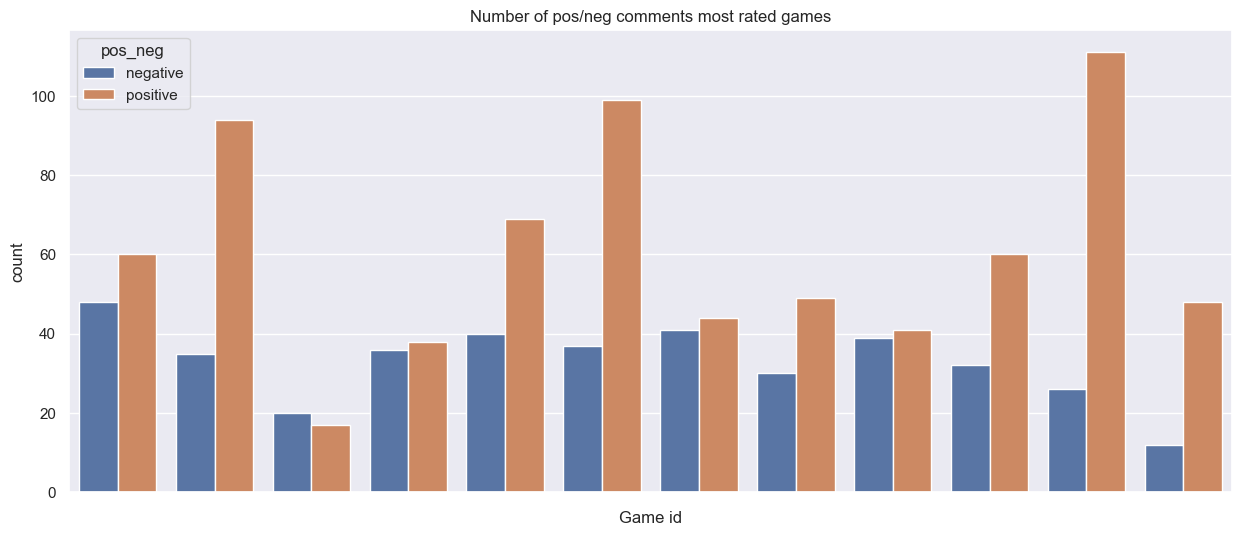

In [13]:
top_games = rev_filter[["Game id", "Rating"]].groupby("Game id").count().reset_index().sort_values(by="Rating", ascending=False).head(12)

plot_pos_neg_games(top_games, comments_all_count, f"Number of pos/neg comments most rated games", all=True)

#### Most rated games frequency difference pos/neg

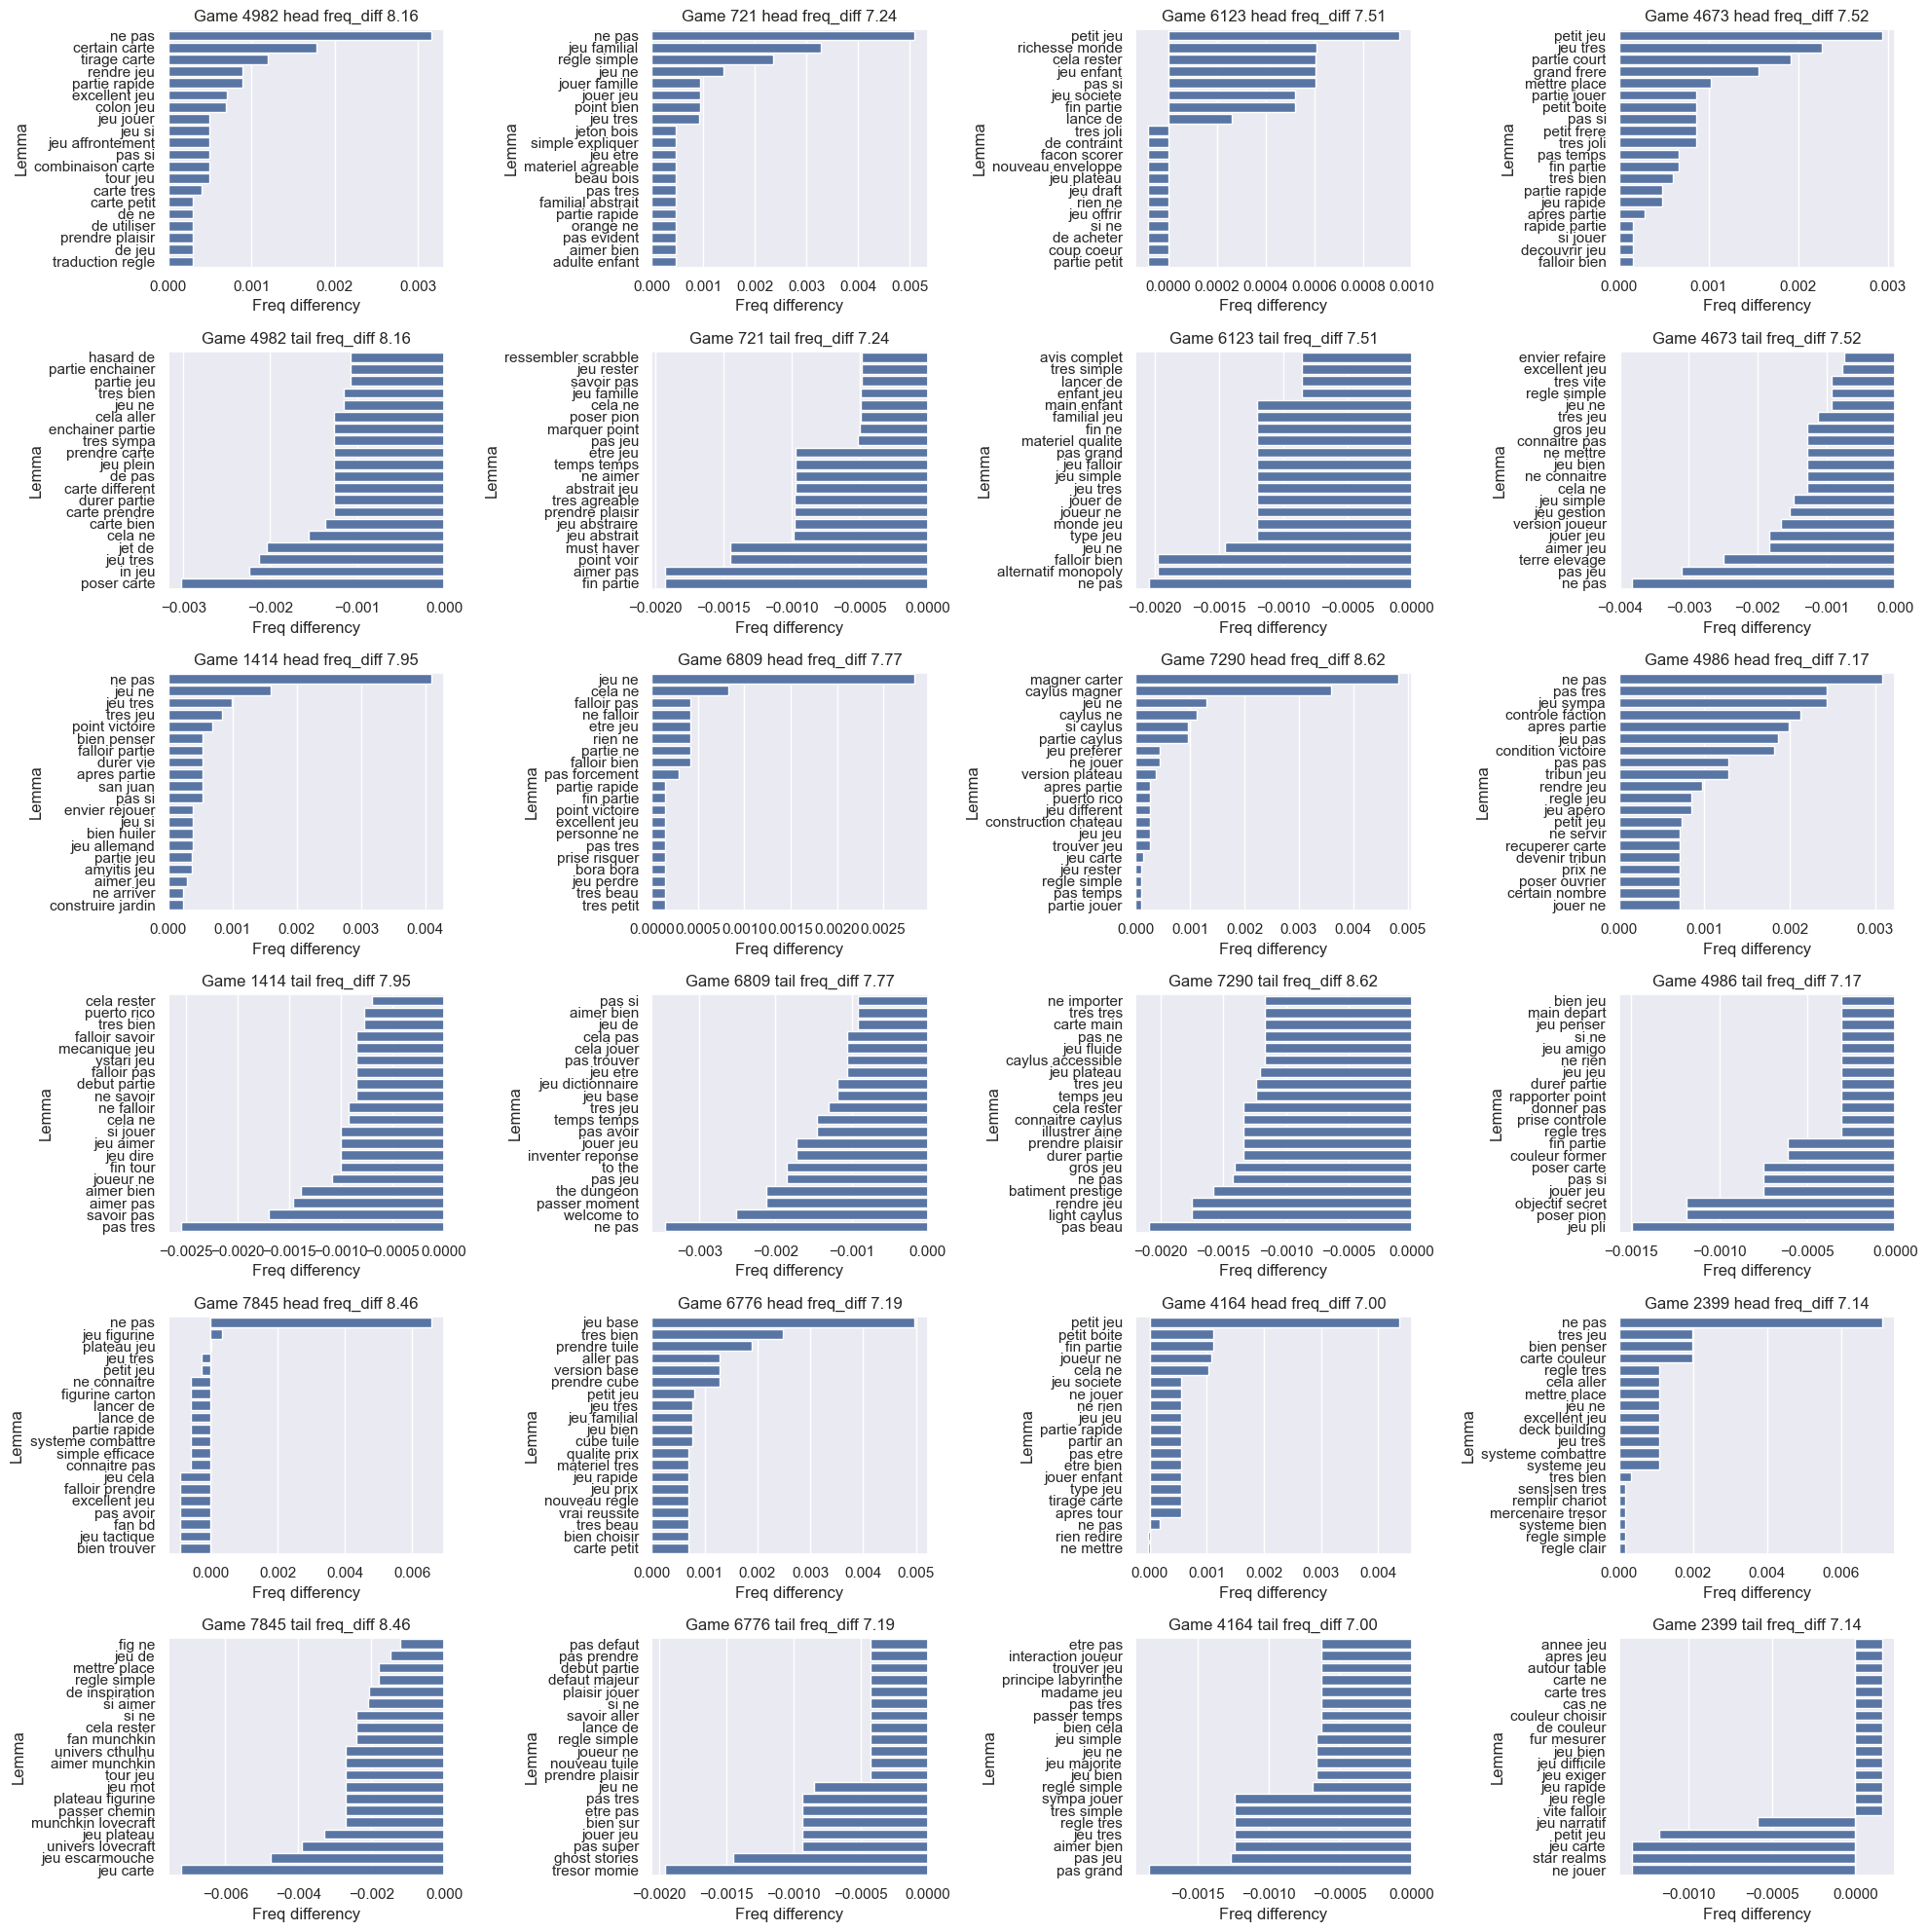

In [14]:
plot_games_Ngrams_freq_diff(top_games["Game id"], 6, 4, (20, 20), BigramCollocationFinder, BigramAssocMeasures.raw_freq, games_means)

### Games per cluster

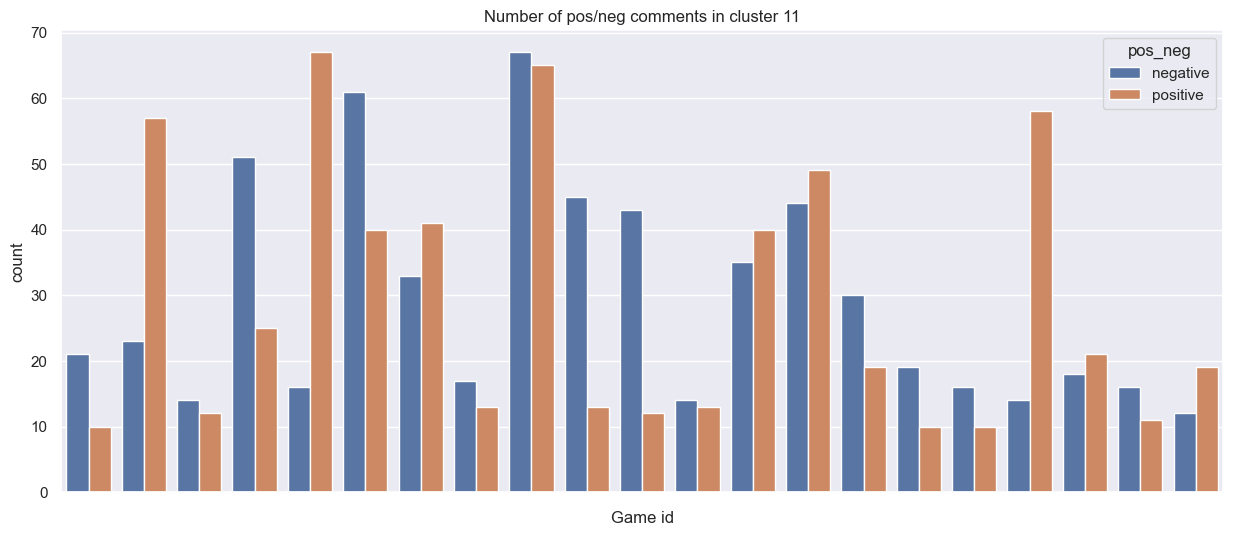

In [15]:
CLUSTER = 11
cluster_games = games_clusters[games_clusters["Cluster"] == CLUSTER]
plot_pos_neg_games(cluster_games, comments_all_count, f"Number of pos/neg comments in cluster {CLUSTER}", all=True)

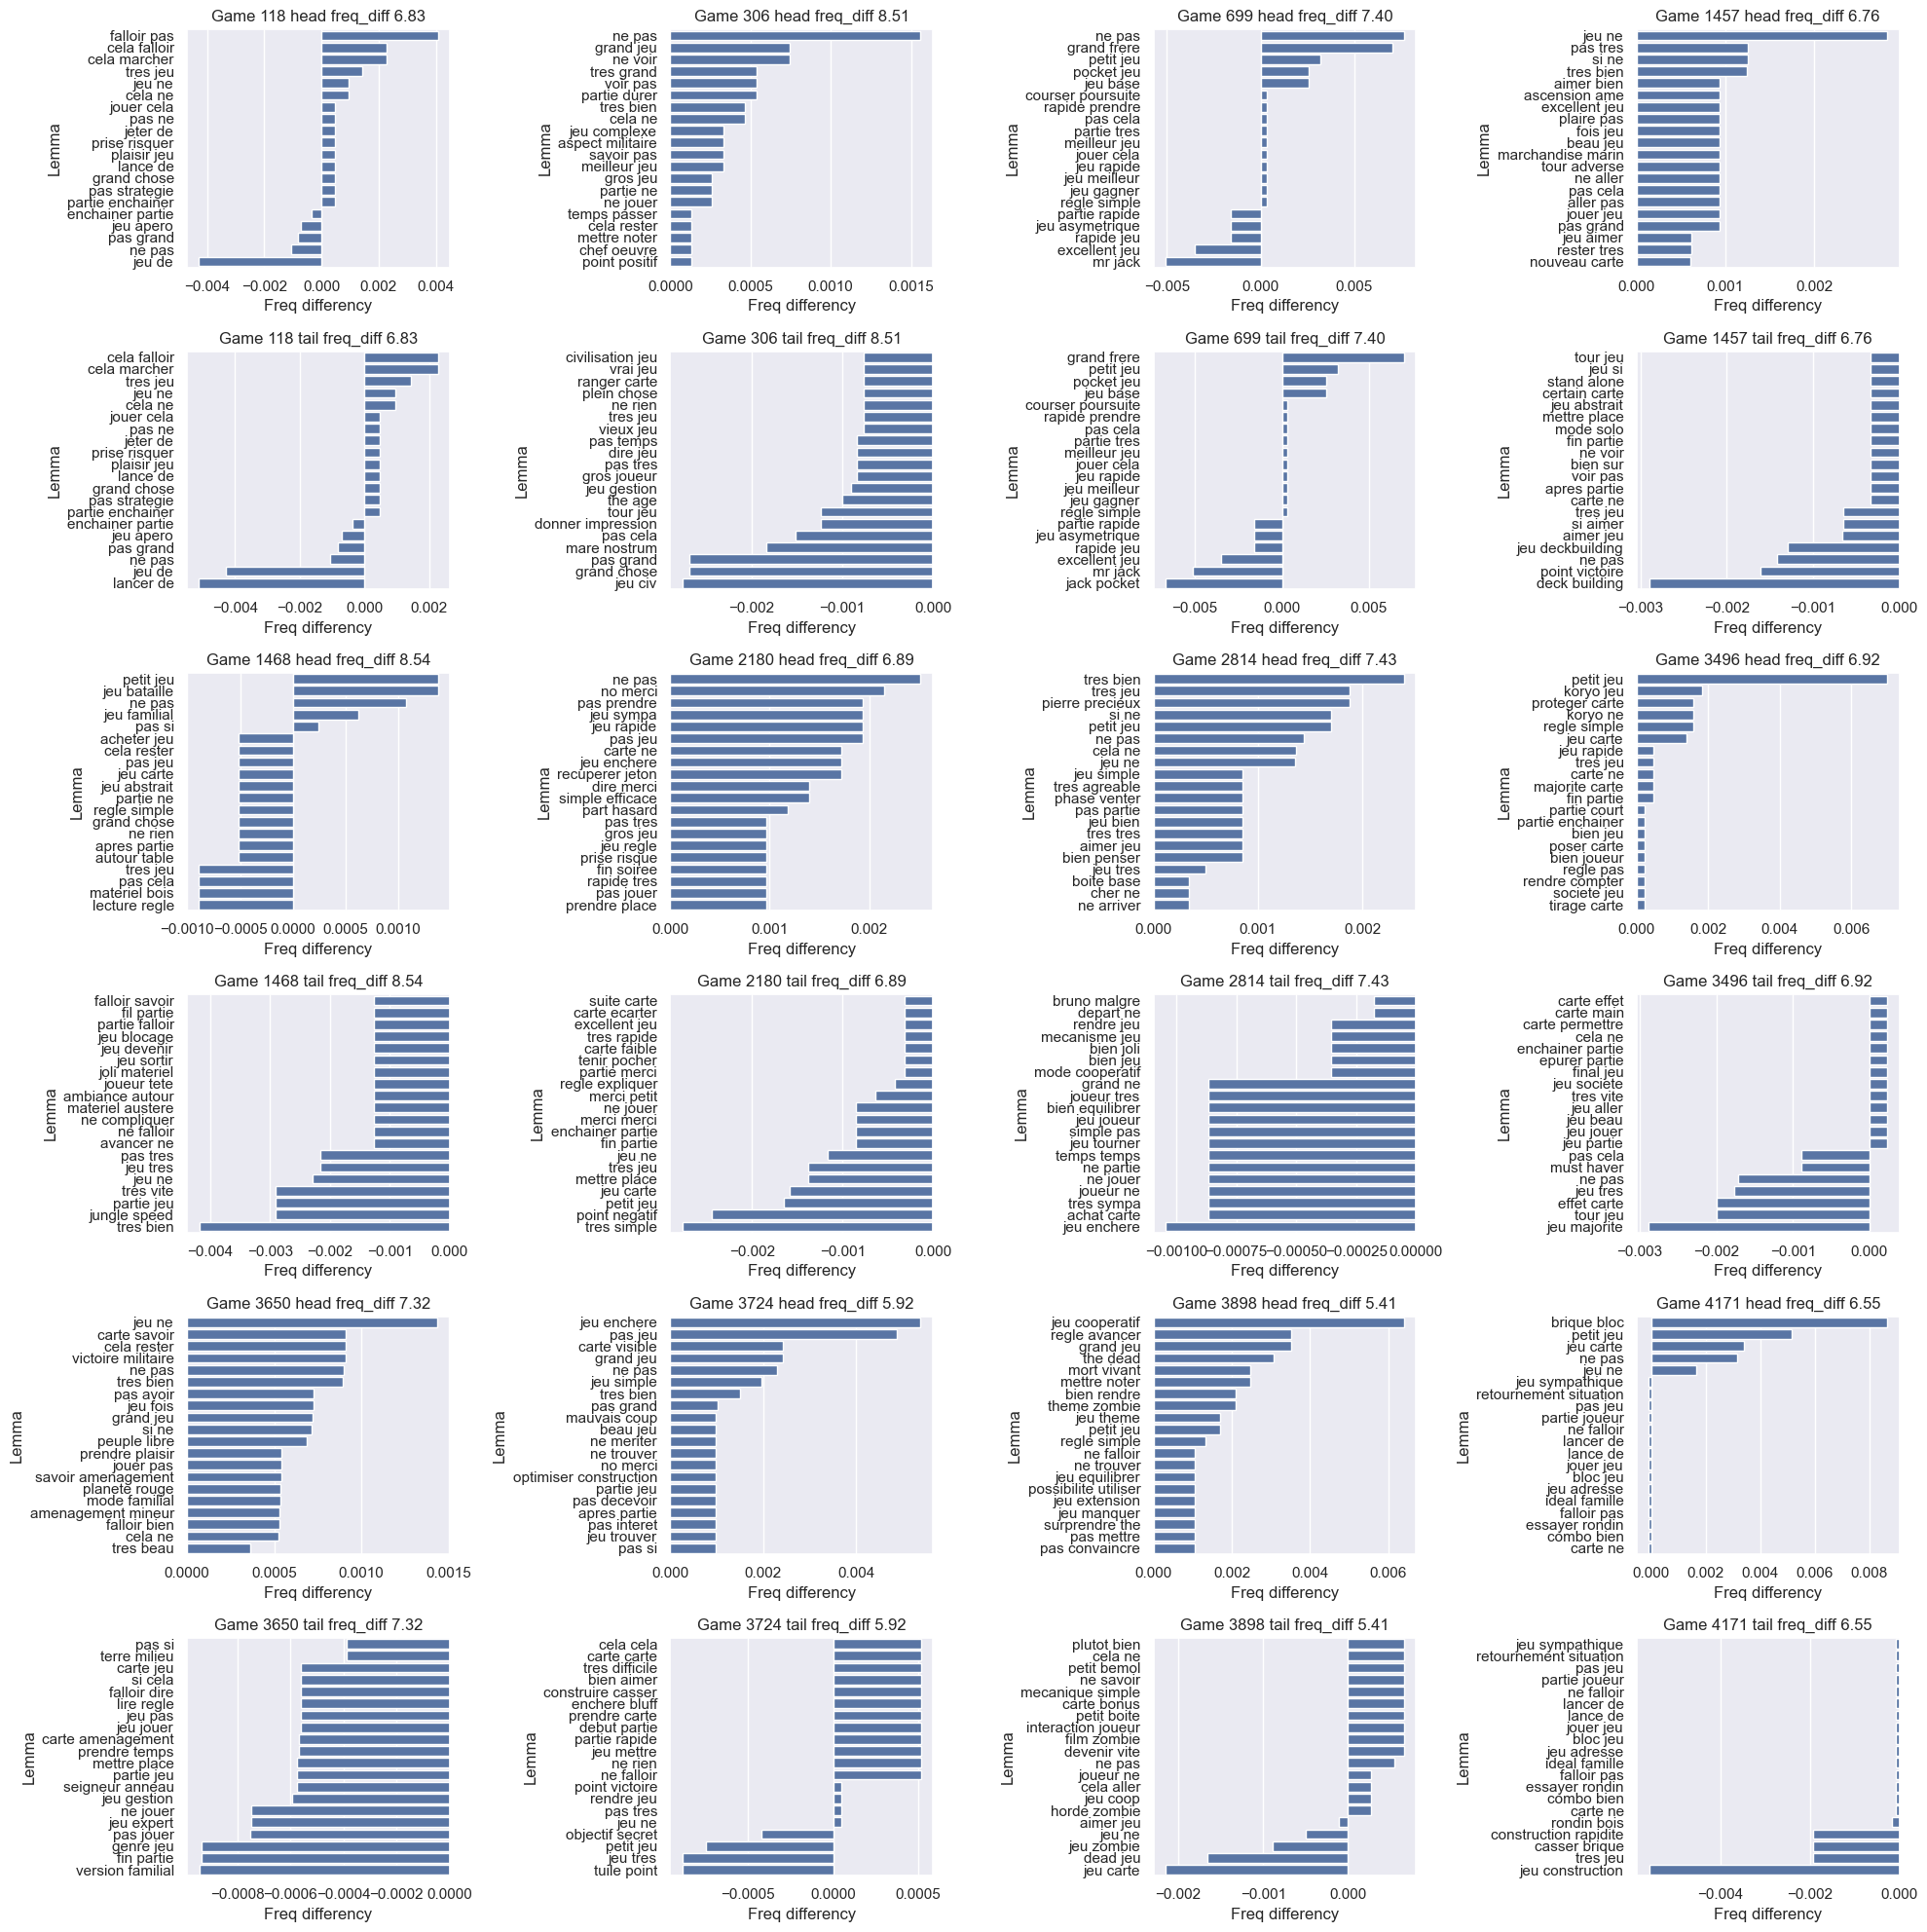

In [16]:
plot_games_Ngrams_freq_diff(cluster_games["Game id"], 6, 4, (20, 20), BigramCollocationFinder, BigramAssocMeasures.raw_freq, games_means)

**Positifs**
- règles simples, simple efficace, jeu simple, traduction règles, fabriquer en france
- plein monstre, bon mécanique, épic quest
- rapide fun, partie court, familial, jeu apéro, cocktail

- apprendre histoire, evenement invention, acquerir connaissance, agréable manipuler
- gros jeu, jeu équilibré, très difficile

- boite metal, matériel qualité, matériel irreprochable, qualité prix, petite boite
- nouvelle version, tempete cerveau

- condition victoire

- coopératif, original

**Négatifs**
- règles simples, trop simple
- très tactique, version familial?
- gros boîte, matériel qualité (austère), casser brique (jeu de construction)
- petit jeu, gros jeu, jeu expert
- passer temps (à lire des règles)
- illustration, couleur limité
- certain déséquilibre

- extension à ajouter
- manque intéraction
- manque le profondeur

### Pos / neg bigrams on all comments

Text(0.5, 1.0, 'Most frequent bigrams in positive reviews')

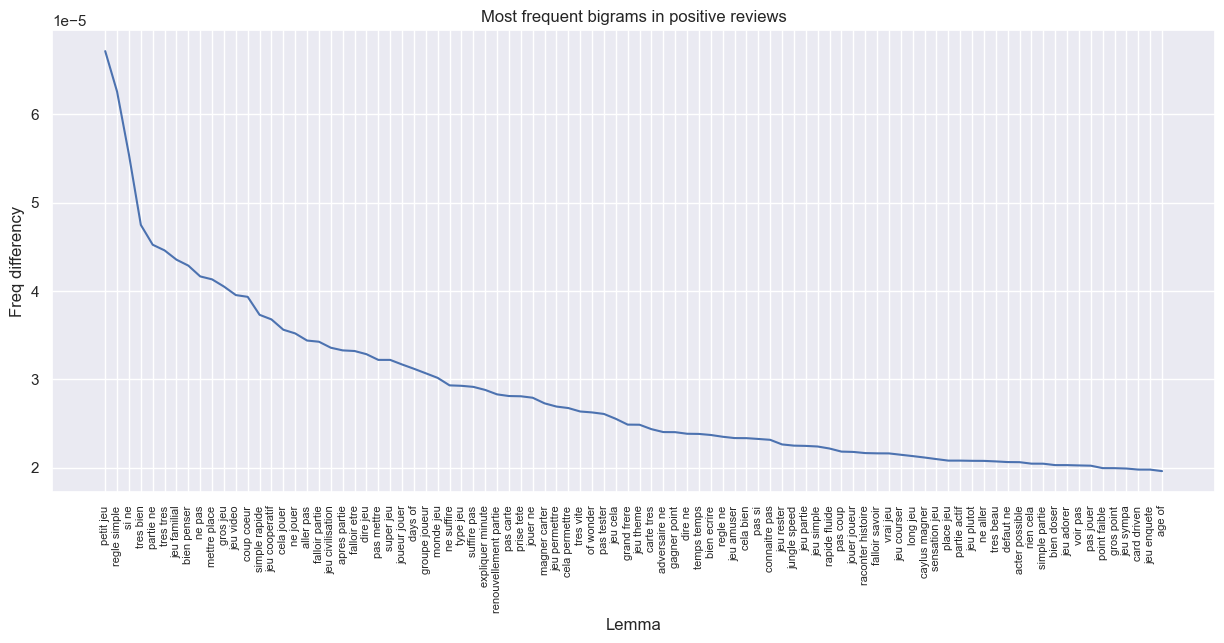

In [17]:
all_bigrams_pos = create_df(BigramCollocationFinder.from_documents(comments_pos["Lemma"].str.split()), BigramAssocMeasures.raw_freq)
all_bigrams_neg = create_df(BigramCollocationFinder.from_documents(comments_neg["Lemma"].str.split()), BigramAssocMeasures.raw_freq)
all_bigrams_freq_diff = ft.diff_freq(all_bigrams_pos, all_bigrams_neg)

# Positive
ax = sns.lineplot(data=all_bigrams_freq_diff.head(90), x="Lemma", y="Freq differency")
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Most frequent bigrams in positive reviews")

Text(0.5, 1.0, 'Most frequent bigrams in negative reviews')

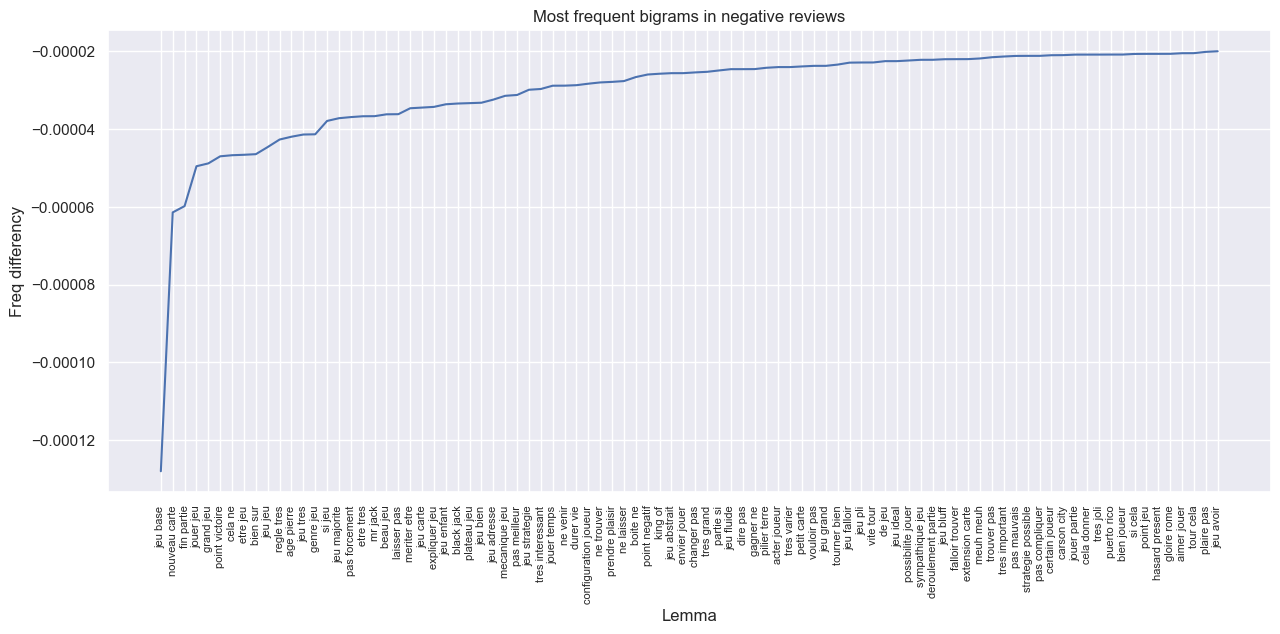

In [18]:
# Negative
ax = sns.lineplot(data=all_bigrams_freq_diff.tail(90).sort_values(by="Freq differency"), x="Lemma", y="Freq differency")
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Most frequent bigrams in negative reviews")

### User recommendation KNN

In [19]:
# Init
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_sim_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
top_users = rev_filter[["User id", "Rating"]].groupby("User id").count().reset_index().sort_values(by="Rating", ascending=False)["User id"].values

games_to_consider = games_clusters["Game id"].values

users_mean = rev_filter[["User id", "Rating"]].groupby("User id").mean().reset_index()
top_users[:5]

array([208,  83,   1,  91, 201])

In [ ]:
def knn_similar_comments(user_id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table):
    def plot_barplots(sim_users_neg, sim_users_pos, user_neg, user_pos):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

        # Negatives comments
        bigrams_neg = create_df(BigramCollocationFinder.from_documents(sim_users_neg["Lemma"].str.split().tolist()),
                                BigramAssocMeasures.raw_freq)

        bigrams_neg_user = create_df( BigramCollocationFinder.from_documents(user_neg["Lemma"].str.split().tolist()),
                                BigramAssocMeasures.raw_freq)
        
        bigrams_neg = bigrams_neg[bigrams_neg["Lemma"].isin(bigrams_neg_user["Lemma"])]

        # Find intersection
        bigrams_neg = bigrams_neg[bigrams_neg["Lemma"].isin(bigrams_neg_user["Lemma"])]
        bigrams_neg_user = bigrams_neg_user[bigrams_neg_user["Lemma"].isin(bigrams_neg["Lemma"])]

        # Positive comments
        bigrams_pos = create_df(BigramCollocationFinder.from_documents(sim_users_pos["Lemma"].str.split().tolist()),
                                BigramAssocMeasures.raw_freq)

        bigrams_pos_user = create_df( BigramCollocationFinder.from_documents(user_pos["Lemma"].str.split().tolist()),
                                BigramAssocMeasures.raw_freq)
        
        # Find intersection
        bigrams_pos = bigrams_pos[bigrams_pos["Lemma"].isin(bigrams_pos_user["Lemma"])]
        bigrams_pos_user = bigrams_pos_user[bigrams_pos_user["Lemma"].isin(bigrams_pos["Lemma"])]


        sns.barplot(data=bigrams_neg.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax1)
        sns.barplot(data=bigrams_pos.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax2)

        sns.barplot(data=bigrams_neg_user.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax1, color="r", alpha=0.5)
        sns.barplot(data=bigrams_pos_user.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax2, color="r", alpha=0.5)

        ax1.set_title(f"Negative bigrams for user {user_id} (id)")
        ax2.set_title(f"Positive bigrams for user {user_id} (id)")

        plt.tight_layout()
        return ax1, ax2

    user_ind = users_table[users_table == user_id].index[0]
    games_to_hide = np.random.choice(games_to_consider, size=200, replace=False)

    hidden_games = np.intersect1d(games_table[games_table.isin(games_to_hide)].index, mask_ratings[user_ind, :].nonzero()[0])

    prev_ratings, prev_mask_ratings = matrix_ratings[user_ind, :], mask_ratings[user_ind, :], 
    prev_sim = cos_sim_matrix[user_ind, :]

    # hide games
    matrix_ratings[user_ind, hidden_games] = 0
    mask_ratings[user_ind, hidden_games] = 0

    recalc_cos_similarity(user_ind, matrix_ratings, cos_sim_matrix)

    sim_users =  get_KNN(cos_sim_matrix, 40, user_ind)
    pred_ratings, mask_pred_ratings = predict_ratings_baseline(matrix_ratings, mask_ratings,
                                                                sim_users, cos_sim_matrix, user_ind)
    
    # restore
    matrix_ratings[user_ind, :], mask_ratings[user_ind, :] = prev_ratings, prev_mask_ratings
    cos_sim_matrix[user_ind, :], cos_sim_matrix[:, user_ind] = prev_sim, prev_sim

    diff = np.abs(matrix_ratings[user_ind, hidden_games] - pred_ratings[hidden_games])

    ALLOW_ERR = 2
    user_mean = users_mean.loc[users_mean["User id"] == user_id, "Rating"].item()
    pos, neg = pred_ratings[hidden_games] < user_mean, pred_ratings[hidden_games] > user_mean

    neg_pred_games = hidden_games[np.argwhere(neg & (diff < ALLOW_ERR)).flatten()]
    pos_pred_games = hidden_games[np.argwhere(pos & (diff < ALLOW_ERR)).flatten()]

    # Find games ids
    neg_pred_games = games_table[games_table.index.isin(neg_pred_games)].values
    pos_pred_games =  games_table[games_table.index.isin(pos_pred_games)].values

    # Find users ids
    sim_users = users_table[users_table.index.isin(sim_users)].values
    sim_users_neg = comments_all[comments_all["Game id"].isin(neg_pred_games) & comments_all["User id"].isin(sim_users)]
    sim_users_pos = comments_all[comments_all["Game id"].isin(pos_pred_games) & comments_all["User id"].isin(sim_users)]
    print(pos_pred_games)
    user_pos = comments_all[(comments_all["Game id"].isin(neg_pred_games)) & (comments_all["User id"] == user_id)]
    user_neg = comments_all[(comments_all["Game id"].isin(pos_pred_games)) & (comments_all["User id"] == user_id)]

    print(f"User id : {user_id}, nb correct negative : {neg_pred_games.shape[0]}, nb correct positives : {pos_pred_games.shape[0]}")
    print(sim_users_neg.shape, sim_users_pos.shape, user_pos.shape, user_neg.shape)
    plot_barplots(sim_users_neg, sim_users_pos, user_neg, user_pos)


[  715  1267  1355  2112  2436  2532  5417  6365  6372  6421  6469  6692
  6828  7758  8901  9631 10409]
User id : 208, nb correct negative : 85, nb correct positives : 17
(786, 5) (118, 5) (65, 5) (10, 5)
                 Lemma      Freq
0               ne pas  0.010571
1               jeu ne  0.002383
3              pas jeu  0.001318
4             jeu tres  0.001268
6         regle simple  0.001065
11          fin partie  0.000887
12            jeu bien  0.000811
13             cela ne  0.000786
19       excellent jeu  0.000684
43           jouer jeu  0.000482
51             jeu pas  0.000456
49            cela jeu  0.000456
55        debut partie  0.000431
60       decouvrir jeu  0.000406
67           si joueur  0.000406
77         tres simple  0.000380
117        bien penser  0.000279
121    jeu cooperation  0.000279
135       prendre main  0.000279
165         pas besoin  0.000254
167         penser jeu  0.000254
150        jeu devenir  0.000254
152       jouer partie  0.000254
19

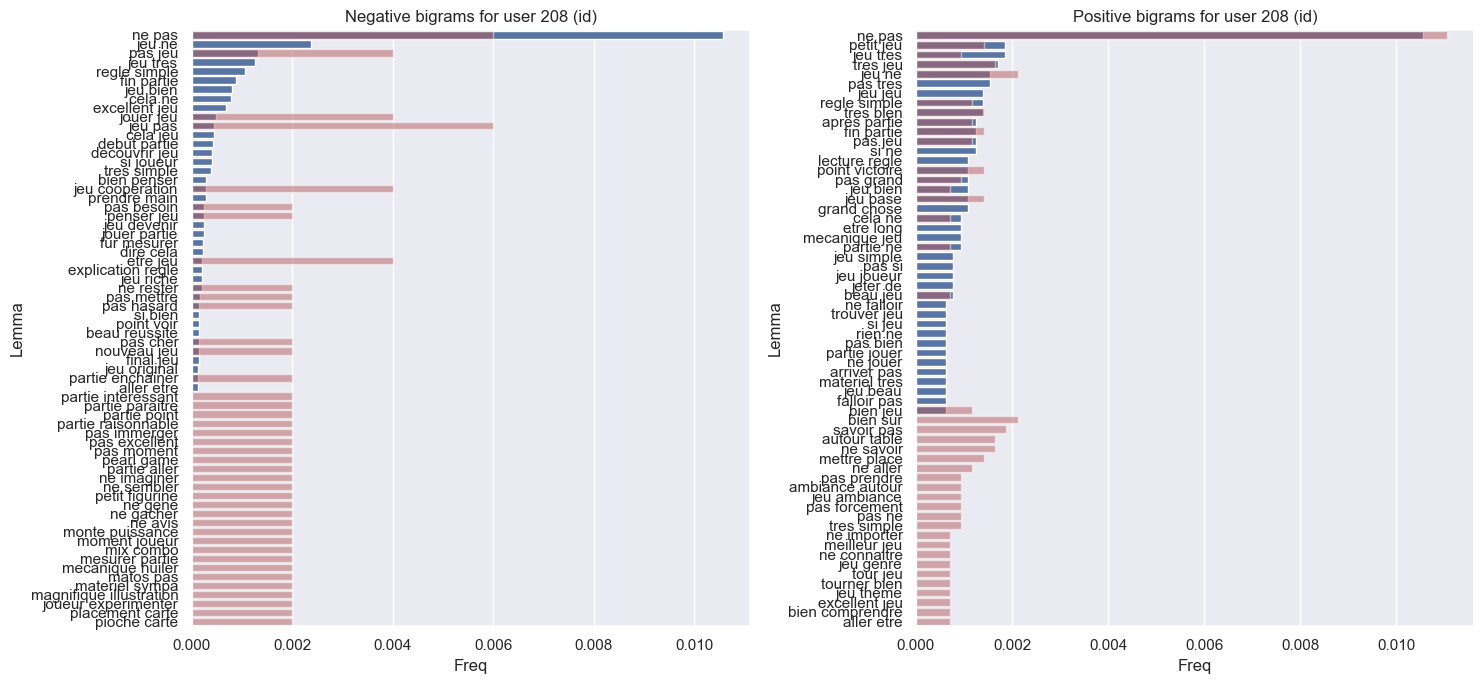

In [82]:
np.random.seed(90)
knn_similar_comments(208, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table)

User id : 83, nb correct negative : 45, nb correct positives : 29
(513, 5) (219, 5)


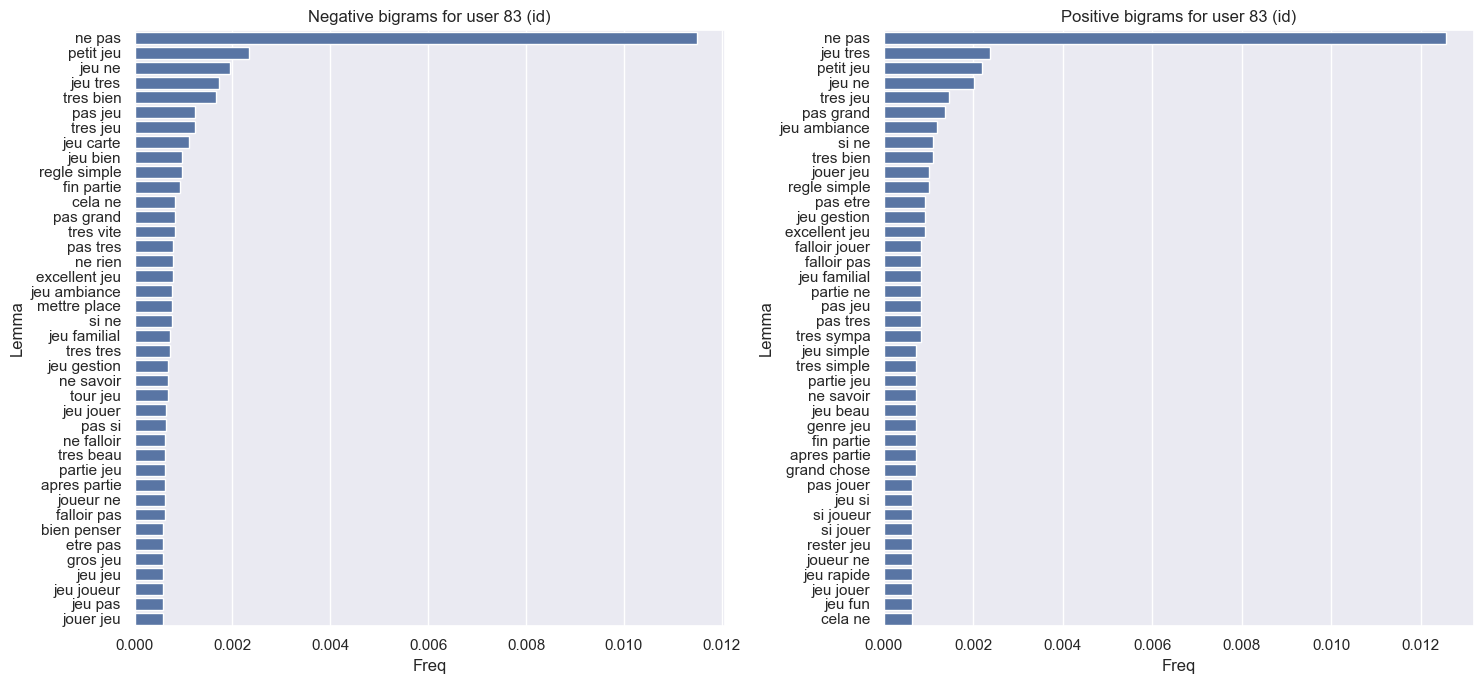

In [41]:
np.random.seed(42)
knn_similar_comments(83, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table)

User id : 91, nb correct negative : 26, nb correct positives : 23
(199, 5) (142, 5)


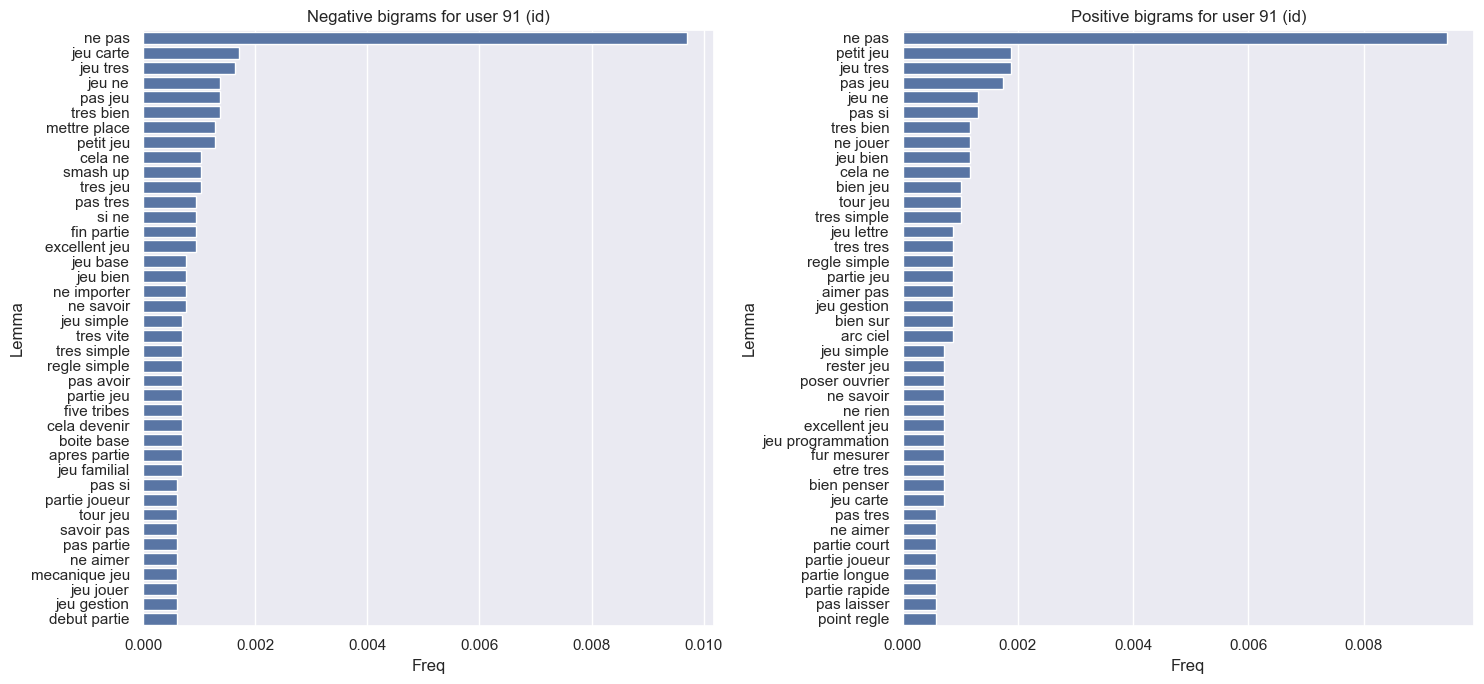

In [42]:
np.random.seed()
knn_similar_comments(91, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table)

In [335]:
fpos = words_freq(lemmas_pos, corpus)
fneg = words_freq(lemmas_neg, corpus)

fpos = fpos.sort_values(by=['Freq'], ascending = False)
fneg = fneg.sort_values(by=['Freq'], ascending = False)

fdiff = ft.diff_freq(fpos,fneg) # si valeur >= 0, alors + grande frequence dans fpos que fneg 
fdiff

,Lemma,Freq differency
3123,ne,0.023527
2576,jeu,0.017788
1096,coup,0.012465
4322,simple,0.011276
4730,tres,0.011183
...,...,...
2552,jack,-0.006962
3452,phase,-0.007708
3488,pion,-0.008057
3178,nouveau,-0.009303


Text(0.5, 1.0, "Fréquence des Lemmas par type d'avis : corpus 5000")

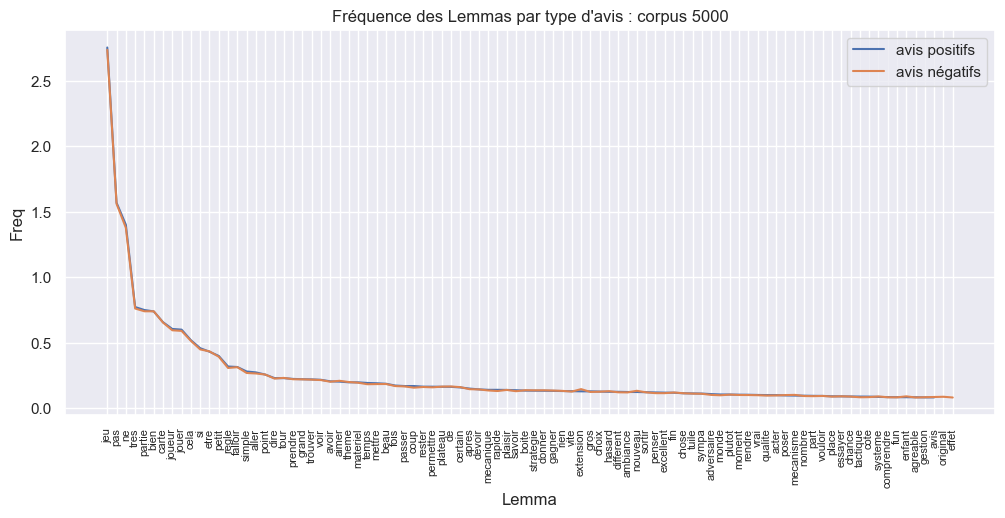

In [337]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fpos.head(90),x='Lemma',y='Freq',label='avis positifs')
ax = sns.lineplot(fneg.head(90),x='Lemma',y='Freq',label='avis négatifs')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Fréquence des Lemmas par type d'avis : corpus 5000")

On remarque que pour 2000 mots, tous les mots dans fpos sont aussi dans fneg

Text(0.5, 1.0, 'Différence de fréquences : 50 mots + notables avis positifs : corpus 5000')

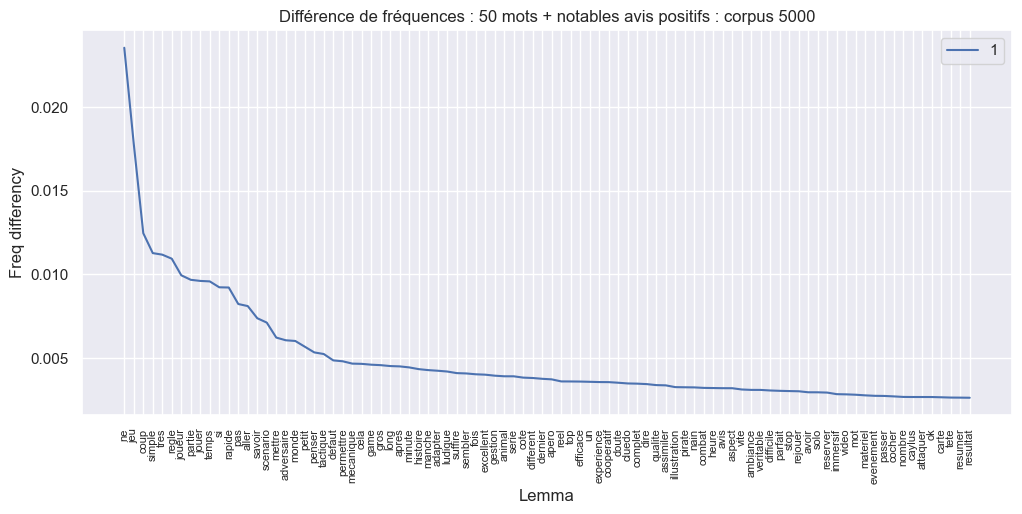

In [338]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff.head(90), x='Lemma',y='Freq differency', label='1')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquences : 50 mots + notables avis positifs : corpus 5000")

Text(0.5, 1.0, 'Différence de fréquence : 50 mots + notables avis négatifs : corpus 5000')

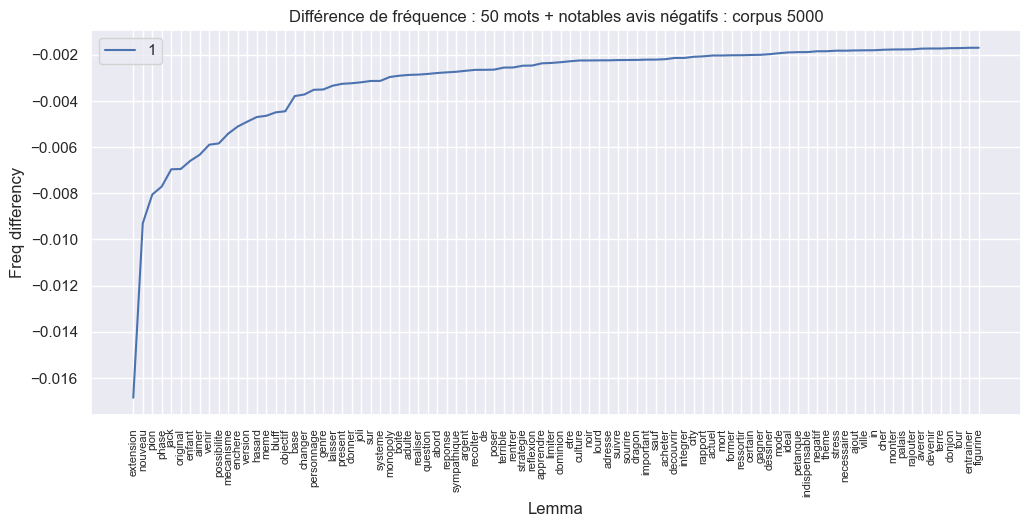

In [339]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff.tail(90)[::-1], x='Lemma',y='Freq differency', label='1')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquence : 50 mots + notables avis négatifs : corpus 5000")

Zoom sur les différences de fréquence


Text(0.5, 1.0, 'Différence de fréquence sur les pires mots : corpus 5000')

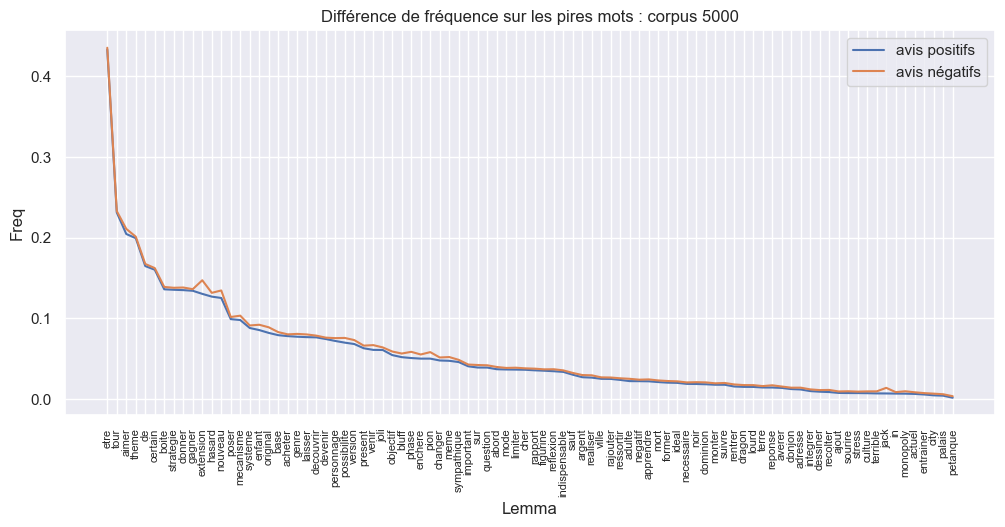

In [340]:
lemmas_neg = fdiff.tail(90)['Lemma'].to_numpy()
pos_tail = fpos[fpos['Lemma'].isin(lemmas_neg)]
neg_tail = fneg[fneg['Lemma'].isin(lemmas_neg)]

ax = sns.lineplot(pos_tail, x='Lemma', y='Freq', label='avis positifs')
ax = sns.lineplot(neg_tail, x='Lemma', y='Freq', label='avis négatifs')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquence sur les pires mots : corpus 5000")

Text(0.5, 1.0, 'Différence de fréquence sur les meilleurs mots : corpus 5000')

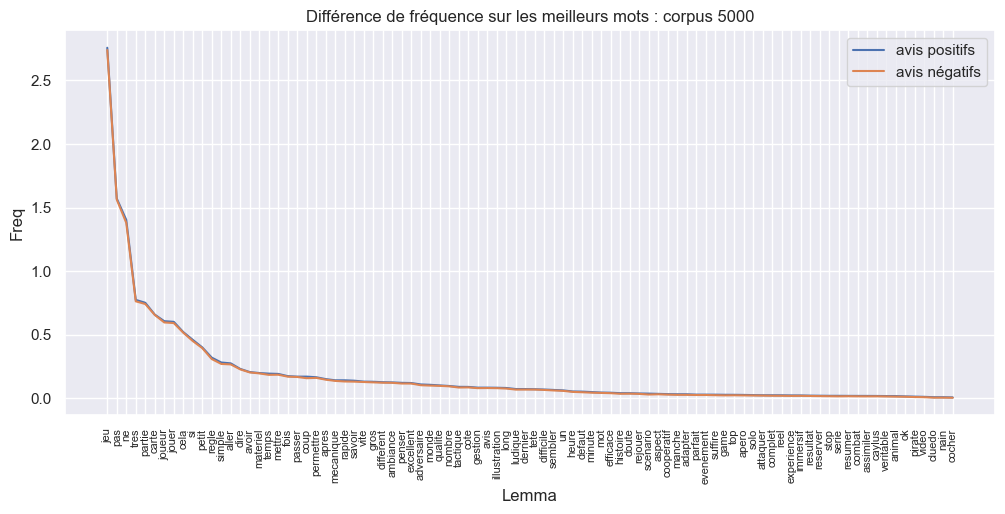

In [341]:
lemmas_neg = fdiff.head(90)['Lemma'].to_numpy()
pos_head = fpos[fpos['Lemma'].isin(lemmas_neg)]
neg_head = fneg[fneg['Lemma'].isin(lemmas_neg)]

ax = sns.lineplot(pos_head, x='Lemma', y='Freq', label='avis positifs')
ax = sns.lineplot(neg_head, x='Lemma', y='Freq', label='avis négatifs')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquence sur les meilleurs mots : corpus 5000")

Visualisation par types de mots

In [342]:
lemmas_sp = lemmas[~lemmas["Lemma"].isna()]
lemmas_sp = lemmas_sp[lemmas_sp['Part of speech'].isin(['ADJ', 'NOM', "VER", "NEG"])]
lemmas_sp_np = lemmas_sp[['Lemma', "Part of speech"]].to_numpy()

In [343]:
lemma_speech = lemmas_sp[['Lemma', 'Part of speech']]
lemma_speech['Part of speech'].unique()

array(['NOM', 'ADJ', 'VER', 'NEG'], dtype=object)

In [344]:
# get only verbs
lemma_verb = lemma_speech[lemma_speech['Part of speech'].isin(['VER'])]
fdiff_verb = fdiff[fdiff['Lemma'].isin(lemma_verb['Lemma'].unique())].sort_values(by=['Freq differency'], ascending=False)
lemma_verb['Lemma'].unique()

array(['envier', 'rejouer', 'essayer', ..., 'grenouiller', 'biere',
       'pleurer'], dtype=object)

In [345]:
fdiff_verb.shape

(1337, 2)

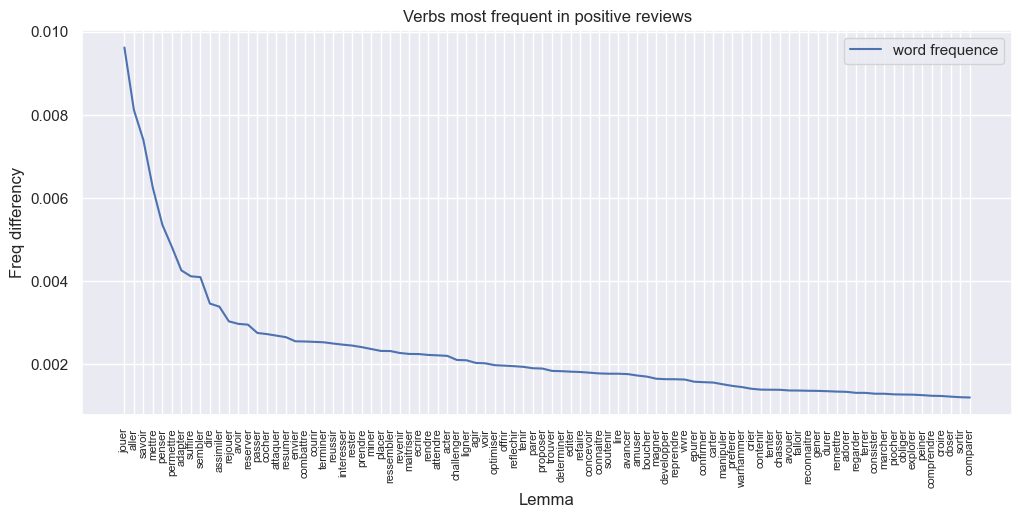

In [346]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_verb.head(90), x='Lemma',y='Freq differency', label='word frequence')
plt.title("Verbs most frequent in positive reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

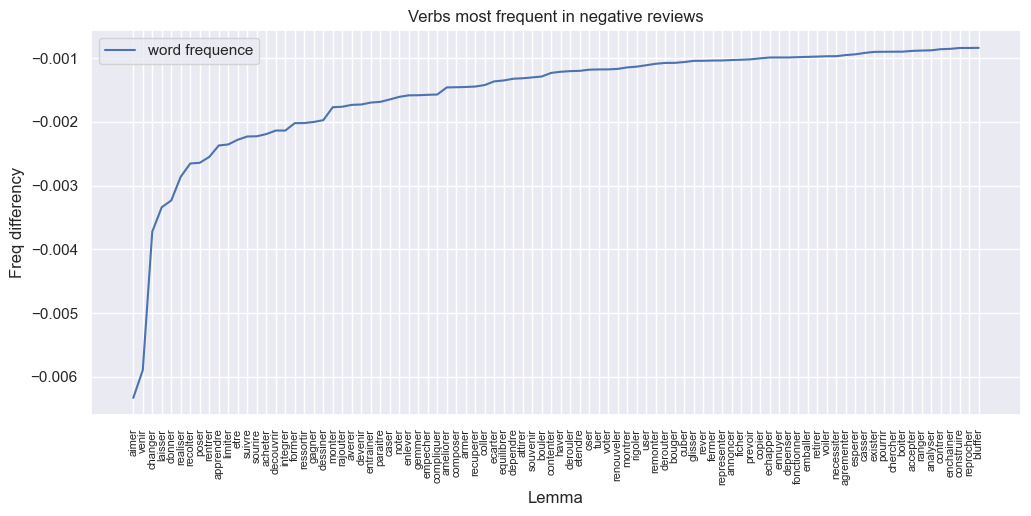

In [347]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_verb.tail(90)[::-1], x='Lemma',y='Freq differency', label='word frequence')
plt.title("Verbs most frequent in negative reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

In [348]:
# get only adj
lemma_adj = lemma_speech[lemma_speech['Part of speech'].isin(['ADJ'])]
fdiff_adj = fdiff[fdiff['Lemma'].isin(lemma_adj['Lemma'].unique())].sort_values(by=['Freq differency'], ascending=False)
lemma_adj['Lemma'].unique()

array(['joli', 'sensible', 'leger', ..., 'entrepot', 'specialiste',
       'flechette'], dtype=object)

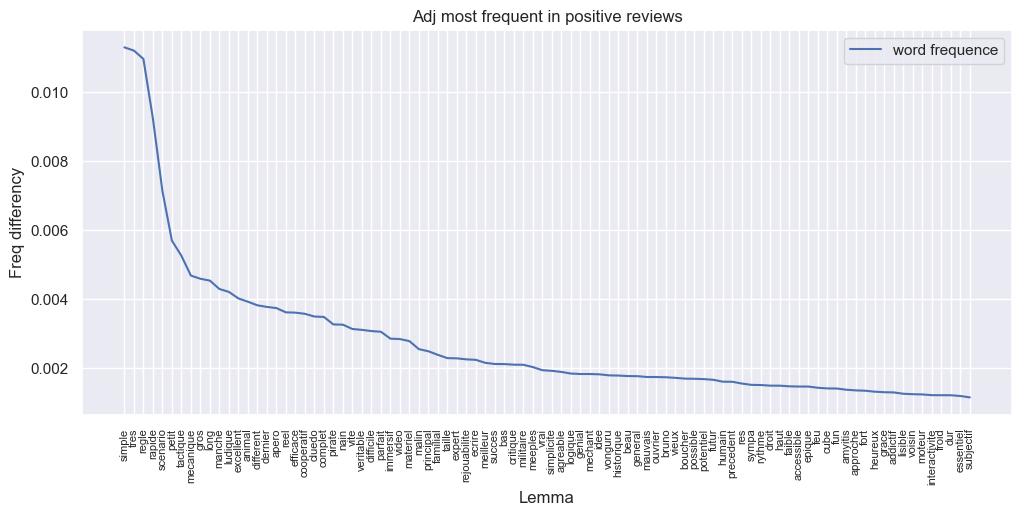

In [349]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_adj.head(90), x='Lemma',y='Freq differency', label='word frequence')
plt.title("Adj most frequent in positive reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

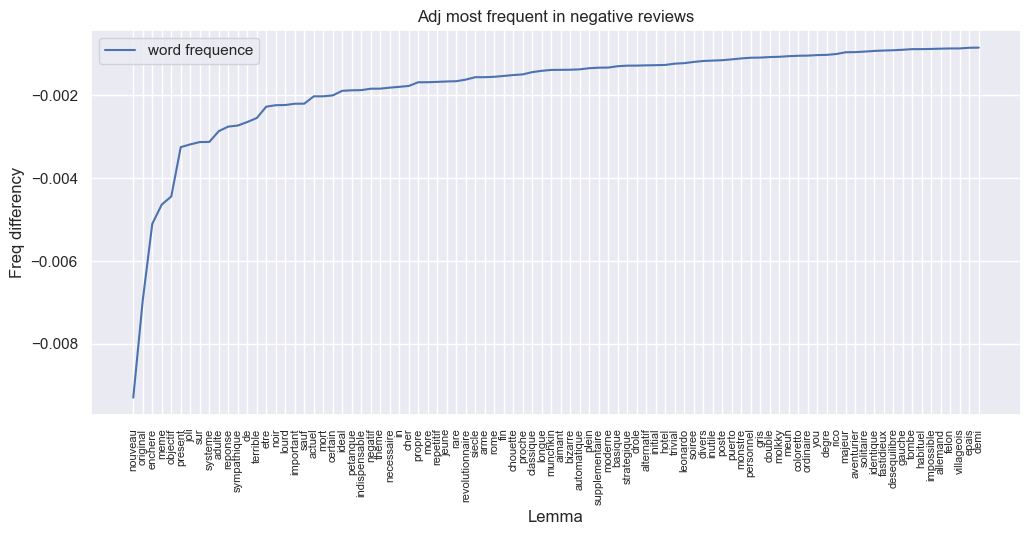

In [350]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_adj.tail(90)[::-1], x='Lemma',y='Freq differency', label='word frequence')
plt.title("Adj most frequent in negative reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

# color one label
for label, position in zip(ax.get_xticklabels(), ax.get_xticks()):
    if label.get_text() == 'enfantin':
        label.set_color("blue")
        label.set_fontweight('bold')

In [351]:
# get only nom
lemma_nom = lemma_speech[lemma_speech['Part of speech'].isin(['NOM'])]
fdiff_nom = fdiff[fdiff['Lemma'].isin(lemma_nom['Lemma'].unique())].sort_values(by=['Freq differency'], ascending=False)
lemma_nom['Lemma'].unique()

array(['voyage', 'aile', 'papillon', ..., 'allechant', 'reunir',
       'reessayer'], dtype=object)

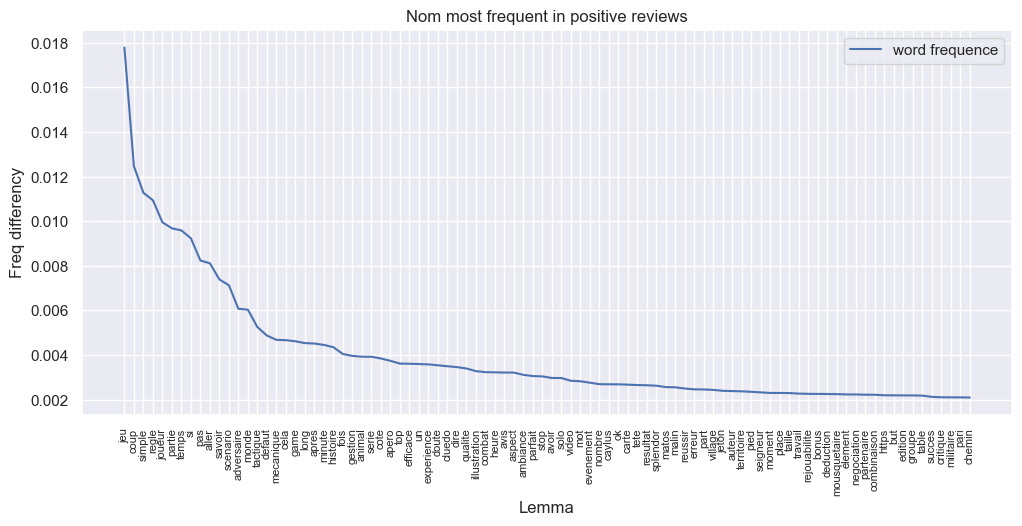

In [352]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_nom.head(90), x='Lemma',y='Freq differency', label='word frequence')
plt.title("Nom most frequent in positive reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

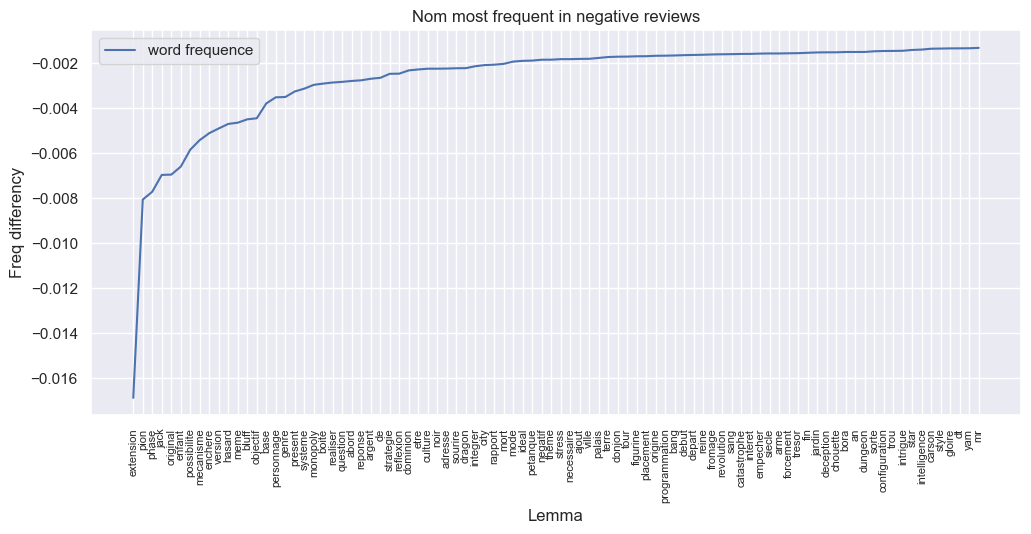

In [353]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_nom.tail(90)[::-1], x='Lemma',y='Freq differency', label='word frequence')
plt.title("Nom most frequent in negative reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)